In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.planar_clusters.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Meshcat url:  http://127.0.0.1:7001/static/


In [3]:
# Sample a dataset of scenes from the default grammar params.
# Draw a random sample from the grammar and visualize it.
# (Cache output.)
torch.random.manual_seed(2)
N_samples = 3
RESAMPLE = True
scenes_file = "sampled_scenes_%d.dat" % N_samples

ground_truth_grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4)
)

if not os.path.exists(scenes_file) or RESAMPLE:
    samples = []
    for k in range(N_samples):
        tree = ground_truth_grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))

    with open(scenes_file, "wb") as f:
        pickle.dump(samples, f)

with open(scenes_file, "rb") as f:
    samples = pickle.load(f)
print("Loaded %d scenes." % len(samples))
observed_node_sets = [x[1] for x in samples]

Loaded 3 scenes.


In [30]:
# Initialize a grammar with wide parameter guesses.
grammar = SpatialSceneGrammar(
    root_node_type = Desk,
    root_node_tf = torch.eye(4),
    sample_params_from_prior=False
)
# Force parameter guesses for rules as wide as possible.
# TODO: Make this a grammar method.
for node_type in grammar.all_types:
    for xyz_param_dict, rot_param_dict in grammar.rule_params_by_node_type[node_type.__name__]:
        if "width" in xyz_param_dict.keys():
            xyz_param_dict["width"].set(torch.ones_like(xyz_param_dict["width"]()) * 5.)
        

def do_vis(tree):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled_in_progress")
    
def get_posterior_tree_samples_from_observation(grammar, observed_nodes, num_mcmc_steps=15, subsample_rate=3, verbose=0):
    draw_scene_tree_contents_meshcat(
        SceneTree.make_from_observed_nodes(observed_nodes), zmq_url=vis.window.zmq_url, prefix="observed"
    )
    
    # Use a MIP to get MAP structure.
    mip_results = infer_mle_tree_with_mip(
        grammar, observed_nodes, verbose=verbose, max_scene_extent_in_any_dir=10.
    )
    mip_optimized_tree = get_optimized_tree_from_mip_results(mip_results)
    if not mip_optimized_tree:
        return None
    # Use NLP to refine that to a MAP estimate.
    refinement_results = optimize_scene_tree_with_nlp(mip_optimized_tree, verbose=verbose)
    refined_tree = refinement_results.refined_tree

    # And sample trees around that MAP estimate with the
    # same structure.
    sampled_trees = do_fixed_structure_mcmc(
        grammar, refined_tree, num_samples=num_mcmc_steps, verbose=verbose,
        perturb_in_config_space=True, translation_variance=1.0, rotation_variance=1.0,
        do_hit_and_run_postprocess=False, vis_callback=do_vis
    )
    
    # Finally, subsample the sampled trees as requested and return
    # the sampled set.
    return sampled_trees[::subsample_rate]

def collect_posterior_sample_sets(grammar, observed_node_sets):
    posterior_sample_sets = []
    for observed_nodes in tqdm(observed_node_sets, desc='Collecting posterior samples'):
        posterior_samples = get_posterior_tree_samples_from_observation(
            grammar, observed_nodes, verbose=0, subsample_rate=2, num_mcmc_steps=10)
        if posterior_samples is not None:
            posterior_sample_sets.append(posterior_samples)
    return posterior_sample_sets
posterior_sample_sets = collect_posterior_sample_sets(grammar, observed_node_sets)

In [5]:
torch.save(grammar, "/tmp/test_saved_grammar.torch")
orig_grammar = torch.load("/tmp/test_saved_grammar.torch")

In [28]:
def fit_grammar_params_to_sample_sets(grammar, posterior_sample_sets):
    ## Try hand-fitting the node and rule parameters, assuming an uninformative prior.
    observed_child_sets_per_node_type = {}
    for node_type in grammar.all_types:
        observed_child_sets_per_node_type[node_type.__name__] = []
    for sample_set in posterior_sample_sets:
        for tree in sample_set:
            for node in tree:
                if isinstance(node, TerminalNode):
                    pass
                observed_child_sets_per_node_type[type(node).__name__].append( (node, tree.get_children(node)) )

    for node_type in grammar.all_types:

        ## Fit the child weights for the node type.
        observed_child_sets = observed_child_sets_per_node_type[node_type.__name__]
        if issubclass(node_type, AndNode):
            continue
        elif issubclass(node_type, OrNode):
            # Sum up the rule_k weights, and set
            # the new weighting to the average.
            count = torch.zeros(len(node_type.generate_rules()))
            for (_, children) in observed_child_sets:
                for child in children:
                    count[child.rule_k] += 1
            avg_count = count / torch.sum(count)
            grammar.params_by_node_type[node_type.__name__].set(avg_count)
        elif issubclass(node_type, GeometricSetNode):
            # Record average count of children, whose inverse
            # is a maximum likelihood estimate of p.
            # https://en.wikipedia.org/wiki/Geometric_distribution#Statistical_inference
            n_children = [len(children) for (_, children) in observed_child_sets]
            p = 1./torch.mean(torch.tensor(n_children, dtype=torch.double))
            grammar.params_by_node_type[node_type.__name__].set(p)
        elif issubclass(node_type, IndependentSetNode):
            # For each child, record how often it's active.
            count = torch.zeros(len(node_type.generate_rules()))
            for (_, children) in observed_child_sets:
                for child in children:
                    count[child.rule_k] += 1.
            count /= len(observed_child_sets)
            grammar.params_by_node_type[node_type.__name__].set(count)
        elif issubclass(node_type, TerminalNode):
            continue
        else:
            raise NotImplementedError(node_type)

        ## For each rule type expected under this node, find optimal parameters.
        rules = node_type.generate_rules()

        # Go collect all parent/child pairs for the rules.
        parent_child_pairs_for_rules = [[] for k in range(len(rules))]
        if issubclass(node_type, GeometricSetNode):
            # Special case: only one rule that all children
            # correspond to.
            assert len(rules) == 1
            for parent, children in observed_child_sets:
                for child in children:
                    parent_child_pairs_for_rules[0].append((parent, child))
        else:
            for parent, children in observed_child_sets:
                for child in children:
                    parent_child_pairs_for_rules[child.rule_k].append((parent, child))

        for rule_k, (xyz_param_dict, rot_param_dict) in enumerate(
                grammar.rule_params_by_node_type[node_type.__name__]):
            xyz_rule = rules[rule_k].xyz_rule
            rot_rule = rules[rule_k].rotation_rule
            parent_child_pairs = parent_child_pairs_for_rules[rule_k]
            if len(parent_child_pairs) == 0:
                continue
            ## XYZ Rules
            if type(xyz_rule) == WorldBBoxRule:
                # The inferred lb/ub (from which we'll derive center/width)
                # will be the biggest deviation between parent and child.
                offsets = torch.stack([child.translation for (_, child) in parent_child_pairs])
                lb = torch.min(offsets, axis=0)[0]
                ub = torch.max(offsets, axis=0)[0]
                xyz_param_dict["center"].set((lb + ub) / 2.)
                xyz_param_dict["width"].set(ub - lb)
            elif type(xyz_rule) == AxisAlignedBBoxRule:
                # The inferred lb/ub (from which we'll derive center/width)
                # will be the biggest deviation between parent and child.
                offsets = torch.stack([child.translation - parent.translation for (parent, child) in parent_child_pairs])
                lb = torch.min(offsets, axis=0)[0]
                ub = torch.max(offsets, axis=0)[0]
                xyz_param_dict["center"].set((lb + ub) / 2.)
                xyz_param_dict["width"].set(ub - lb)
            else:
                raise NotImplementedError("type %s under node %s" % (type(xyz_rule), node_type))
            ## Rotation rules
            if type(rot_rule) == UnconstrainedRotationRule:
                # No parameters
                pass
            elif type(rot_rule) == UniformBoundedRevoluteJointRule:
                # The inferred lb/ub (from which we'll derive center/width)
                # will be the biggest deviation between parent and child in terms
                # of axis/angle rotation.
                offsets = []
                for parent, child in parent_child_pairs:
                    angle, _ = rot_rule._recover_relative_angle_axis(parent, child)
                    offsets.append(angle)
                offsets = torch.stack(offsets)
                lb = torch.min(offsets)
                ub = torch.max(offsets)
                rot_param_dict["center"].set((lb + ub) / 2.)
                rot_param_dict["width"].set(ub - lb)
    return grammar
fit_grammar_params_to_sample_sets(grammar, posterior_sample_sets)
print("**********************************\n"
      "**********  BEFORE ***************\n"
      "************************************")
orig_grammar.print_params(node_names=["Desk"])
print("**********************************\n"
      "**********  AFTER ***************\n"
      "************************************")
grammar.print_params(node_names=["Desk"])
print("**********************************\n"
      "**********  TRUTH ***************\n"
      "************************************")
ground_truth_grammar.print_params(node_names=["Desk"])


**********************************
**********  BEFORE ***************
************************************
	Desk:
		child weights: [0.2]
		Rule 0:
			XYZ center: Parameter containing:
tensor([0.5000, 0.5000, 0.0000], requires_grad=True)
			XYZ width: tensor([5., 5., 5.], grad_fn=<AddBackward0>)
			Rot center: Parameter containing:
tensor(0., requires_grad=True)
			Rot width: tensor([6.2832], grad_fn=<AddBackward0>)
**********************************
**********  AFTER ***************
************************************
	Desk:
		child weights: [0.3]
		Rule 0:
			XYZ center: Parameter containing:
tensor([0.0484, 0.3992, 0.0000], requires_grad=True)
			XYZ width: tensor([4.0968, 4.7985, 5.0000], grad_fn=<AddBackward0>)
			Rot center: Parameter containing:
tensor(-0.2500, requires_grad=True)
			Rot width: tensor([5.0829], grad_fn=<AddBackward0>)
**********************************
**********  TRUTH ***************
************************************
	Desk:
		child weights: [0.2]
		Rule 0:


In [31]:
state_dict_history = []
for iter_k in range(10):
    state_dict_history.append(deepcopy(grammar.state_dict()))
    posterior_sample_sets = collect_posterior_sample_sets(grammar, observed_node_sets)
    fit_grammar_params_to_sample_sets(grammar, posterior_sample_sets)

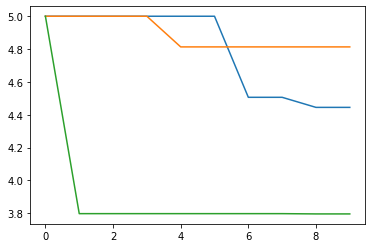

In [41]:
# XYZ width history, illustrative example:
desk_xyz_width_history = []
for state_dict in state_dict_history:
    grammar.load_state_dict(state_dict)
    desk_xyz_width_history.append(grammar.rule_params_by_node_type["Desk"][0][0]["width"]().detach().numpy())
plt.plot(desk_xyz_width_history)

In [ ]:
# And now do gradient descent on the grammar parameters
# by summing the score of all of those trees.

# Reattach tree params to prepare for grad descent.
tree_set = sum(posterior_sample_sets, [])

def calc_mean_score(tree_set):
    total_score = 0.
    total_k = 0.
    for tree in tree_set:
        total_score = total_score + tree.score()
        total_k += 1
    return total_score / total_k

log_by_node_type = {node_type.__name__: [] for node_type in grammar.all_types}
def log_params(grammar):
    for node_type_name, params in grammar.params_by_node_type.items():
        if params is not None:
            log_by_node_type[node_type_name].append(params().detach())
        
optimizer = torch.optim.Adam(grammar.parameters(), lr=0.1)
pbar = tqdm(range(100), desc="Optimizing parameters")
score_history = []
for step_k in pbar:
    # Update parameter settings
    log_params(grammar)
    for tree in tree_set:
        grammar.update_tree_grammar_parameters(tree)
    score = calc_mean_score(tree_set)
    score_history.append(score)
    # Gradient step
    optimizer.zero_grad()
    (-score).backward(retain_graph=True)
    optimizer.step()
    pbar.set_description("Mean score %2.2f" % score)
plt.plot(score_history)
plt.xlabel("Step")
plt.title("Score history")

In [ ]:
# Plot param logs
cm = plt.get_cmap('viridis')
for node_type_name, log in log_by_node_type.items():
    if len(log) > 0:
        plt.figure()
        data = torch.stack(log, axis=0).numpy()
        n_vars = data.shape[1]
        ground_truth_values = ground_truth_grammar.params_by_node_type[node_type_name]()
        for var_k in range(n_vars):
            c = cm(float(var_k) / max(1, (n_vars-1)))
            plt.plot(data[:, var_k], color=c, label="Fit")
            plt.axhline(ground_truth_values[var_k], color=c, linestyle="--", label="GT")
        plt.title(node_type_name + " child weights")
        plt.xlabel("Step")